## Project: Functional Brain Network in Alzheimer's Disease
Author: Yile Wang

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.io
import seaborn as sns
import pandas as pd
import re
import sys
# sys.path.append('../../Metaconnectivity/Python')
# from TS2dFCstream import TS2dFCstream
# from dFCstream2MC import dFCstream2MC
import itertools
import community as community_louvain
# from bct.algorithms import community_louvain
from bct.algorithms.centrality import participation_coef
import netsci.visualization as nsv
import netsci.metrics.motifs as nsm
from matplotlib import ticker

### prepare parcellation

In [52]:
#load the parcellation data
file_name = '../../data4project/ROIs_512.xlsx'

df_parcel = pd.read_excel(file_name, sheet_name='Sheet1')
df_modules = pd.read_excel(file_name, sheet_name='Sheet2')
print(df_parcel)
print(df_modules)

                   Regions    Label_names  Label_id position Hemispheric
0    Temporal Pole Sup L.1       Temporal         1      L.1        Left
1          Frontal Sup L.1        Frontal         2      L.1        Left
2          Frontal Sup L.2        Frontal         2      L.2        Left
3        SupraMarginal L.1  SupraMarginal        24      L.1        Left
4             Fusiform L.1       Fusiform         7      L.1        Left
..                     ...            ...       ...      ...         ...
507          Precuneus R.8      Precuneus        16      R.8       Right
508      Occipital Sup R.8      Occipital         5      R.8       Right
509  Temporal Pole Mid R.5       Temporal         1      R.5       Right
510        Precentral R.14     Precentral        21     R.14       Right
511          Fusiform R.10       Fusiform         7     R.10       Right

[512 rows x 5 columns]
            modules  ids
0          Temporal    1
1           Frontal    2
2          Parietal    3


## All functions

In [53]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = np.zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

def alpha_equation(G, kmin):
    a_tmp = [np.log(ki/(kmin - 0.5)) for ki in degree_sequence(G) if ki>=kmin]
    return 1+len(a_tmp)*(1/sum(a_tmp))

def sigma_equation(G,alpha, kmin):
    a_tmp = [np.log(ki/(kmin - 0.5)) for ki in degree_sequence(G) if ki>=kmin]
    return (alpha - 1) / np.sqrt(len(a_tmp))
def dist_cumu_plots(k, ddist, cdist):

    fig, (ax1, ax2)= plt.subplots(2, figsize=(8,12))
    ax1.bar(k,ddist, width=0.8, bottom=0, color='b') # replace xvalues and barheights!
    ax1.set_title('Degree distribution')
    
    ax2.loglog(k,cdist, label = 'original') # replace xvalues and yvalues!
    plt.legend() 
    plt.grid(True)
    x = np.log(k)
    y = np.log(cdist)
    m = (y[-1]-y[0])/(x[-1]-x[0])
    b = y[0]-m*x[0]
    ax2.loglog(np.exp(x), np.exp(m*x+b), label = 'linear_fitting')
    ax2.set_title('Power law fitting')


def calc_powerlaw(G,kmin=None):
    ddist = degree_distribution(G,normalize=True)
    cdist = cumulative_degree_distribution(G)
    k = np.arange(len(ddist))

    alpha = alpha_equation(G, kmin) # calculate using Newman (8.6)!
    sigma = sigma_equation(G, alpha, kmin) # calculate using Newman (8.7)!
    print( 'alpha: %1.2f +/- sigma: %1.2f' % (alpha,sigma) )
    dist_cumu_plots(k[kmin:],ddist[kmin:], cdist[kmin:])
    plt.legend() 
    plt.grid(True)

def degree_centrality(G, weight = None):
    if weight:
        return G.degree(weight=weight)
    else:
        return G.degree

def print_top_num(G,v, num=5):
    thenodes = list(G.nodes())
    idx_list = [(i,v[i]) for i in range(len(v))]
    idx_list = sorted(idx_list, key = lambda x: x[1], reverse=True)
    for i in range(min(num,len(idx_list))):
        nidx, score = idx_list[i]
        print('  %i. %s (%1.4f)' % (i+1,thenodes[nidx],score))
    return thenodes, idx_list

def scalar_assortativity(G,d):
    x = np.zeros(G.number_of_nodes())
    for i,n in enumerate(G.nodes()):
        x[i] = d[n]

    A = np.array(nx.adjacency_matrix(G).todense().T)
    M = 2*A.sum().sum()
    ki = A.sum(axis=1) #row sum is in-degree
    ko = A.sum(axis=0) #column sum is out-degree
    mu = ( np.dot(ki,x)+np.dot(ko,x) )/M

    R, Rmax = 0, 0
    for i in range(G.number_of_nodes()):
        for j in range(G.number_of_nodes()):
             R += ( A[i,j]*(x[i]-mu)*(x[j]-mu) )/M
             Rmax += ( A[i,j]*(x[i]-mu)**2 )/M

    return R, Rmax

def louvain_community(G):
    partition = community_louvain.best_partition(G)
    return partition

def part_coef(A, module_labels):
    part_coef = participation_coef(A, module_labels, degree='undirected')
    return part_coef

#load the single data
def select_network(id, visual = False):
    single_subj = scipy.io.loadmat(f'../../data4project/fmri_AAL_512/{id}/ROICorrelation_{id}.mat')
    return np.array(single_subj['ROICorrelation'])

# build the network based on df_MC
def build_network(mean_MC, threshold, df_parcel=df_parcel, reverse_path = False):
    G = nx.Graph()
    for i in range(len(mean_MC)):
        for j in range(i+1, len(mean_MC)):
            if mean_MC[i,j] > threshold or mean_MC[i,j] < -threshold:
                if reverse_path:
                    G.add_edge(df_parcel.Regions[i], df_parcel.Regions[j], weight=1-mean_MC[i,j])
                else:
                    G.add_edge(df_parcel.Regions[i], df_parcel.Regions[j], weight=mean_MC[i,j])
    return G


def weighted_degree_centrality(G):
    centrality_vector = [val for (node, val) in G.degree(weight='weight')]
    print('degree centrality, weigted:')
    thenodes, idx = print_top_num(G, centrality_vector, num=10)
    scores = [i for _, i in idx]
    return thenodes, scores

def weighted_eigenvector_centrality(G):
    eigencentrality_vector = [i for i in nx.eigenvector_centrality(G, weight='weight', max_iter=10000).values()]
    print(f'Eigenvector Centrality weighted:')
    thenodes, idx = print_top_num(G, eigencentrality_vector, num=10)
    scores = [i for _, i in idx]
    return thenodes, scores

def compute_partition_from_louvain(G, df_parcel=df_parcel, mode="part_coef"):
    partition = nx.community.louvain_communities(G, seed =42)
    # plt.figure(figsize=(5,5))
    # nx.draw_networkx(G_AD, with_labels=False, node_size=20, width=0.2, edge_color='grey', node_color=list(partition.values()))
    if mode in ["modularity", "modularity_louvain"]:
        modularity_louvain = nx.community.modularity(G, partition)
        return modularity_louvain
    else:
        # matching the partition with the df_parcel
        partition_number = np.zeros(G.number_of_nodes())
        for index, i in enumerate(partition):
            subset = [ix for ix in i]
            for ix in subset:
                # return the index of the region
                all_subset_nodes = df_parcel[df_parcel['Regions'] == ix].index[0]
                partition_number[all_subset_nodes] = index
        A = np.array(nx.adjacency_matrix(G).todense().T)
        part_coef = participation_coef(A, partition_number)
        return part_coef
    
    
# create a function to calculate the average neighbor degree of each node
def average_neighbor_degree(G):
    average_neighbor_degree = []
    for node in G.nodes():
        average_neighbor_degree.append(nx.average_neighbor_degree(G, nodes=[node], weight='weight')[node])
    return average_neighbor_degree


## Motif
def calculate_motif(G):
    A = nx.adjacency_matrix(G, weight=None).todense().T
    f = nsm.motifs(A, algorithm='brute-force' )
    nsv.bar_motifs(f)
    return f
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def calculate_similarity(f1):
    similarity = []
    for i in range(len(f1)):
        for j in range(i+1, len(f1)):
            similarity.append(cosine_similarity(f1[i], f1[j]))
    return similarity


## Graphlets
def graphlets_DD(graphlets_table, orbit_index =0):
    orbit = 'role_'+str(orbit_index)

    SjGk = np.zeros(max(graphlets_table[orbit]))
    for index, i in enumerate(range(1, len(SjGk)+1)):
        SjGk[index] = graphlets_table[graphlets_table[orbit] == i].shape[0]

    TjG = np.sum(SjGk)
    NjGk = SjGk/TjG
    return NjGk

def graphlets_DD_distance(NjGk, NjHk):
    DjGH = np.sqrt(np.sum([(x-y)**2 for x,y in zip(NjGk, NjHk)]))
    AjGH = 1-DjGH
    return AjGH

def graphlets_DD_agreement(graphlets_table1, graphlets_table2, mode = 'arith', number_of_orbits = 67):
    Aj = np.zeros(number_of_orbits-1)
    for oi in range(number_of_orbits-1):
        g1 = graphlets_DD(graphlets_table1, orbit_index = oi)
        g2 = graphlets_DD(graphlets_table2, orbit_index = oi)
        Aj[oi] = graphlets_DD_distance(g1, g2)
    if mode in ['arith']:
        return 1/number_of_orbits*np.sum(Aj)
    elif mode in ['geo']:
        return np.prod(Aj)**(1/number_of_orbits)
    

# scalar assortativity
def make_d_scalar(G, df_parcel):
    d_communities = {}
    for index, region in enumerate(df_parcel['Regions']):

        # d_communities[region] = G.degree(region, weight='weight')
        d_communities[region] = compute_partition_from_louvain(G, mode="part_coef")[index]
    return d_communities

def quick_scalar_assortativity(G, d):
    R, Rmax = scalar_assortativity(G, d)
    return R/Rmax


def average_shortest(Gp):
    S = [Gp.subgraph(c).copy() for c in nx.connected_components(Gp)]
    integration = nx.average_shortest_path_length(S[0], weight='weight')
    return integration


def weighted_average_neighbor(G):
    average_neighbor_degree_vector = average_neighbor_degree(G)
    print(f'Averaging neighor degree, weighted:')
    thenodes, idx = print_top_num(G, average_neighbor_degree_vector, num=10)
    scores = [i for _, i in idx]
    return thenodes, scores


def calculate_diameter(Gp):
    S = [Gp.subgraph(c).copy() for c in nx.connected_components(Gp)]
    return nx.diameter(S[0], weight='weight')


### Label information
SNC: super normal controls;  
NC: normal controls;  
MCI: mild cognitive impairments;  
AD: alzheimer's disease;  

In [54]:
# load groups subtab from mega_table.xlsx from data4project using pandas
group_caseid = pd.read_excel('../../data4project/mega_table.xlsx', sheet_name='groups')
print(group_caseid)
# read txt file sub_id.txt
id_with_group = np.loadtxt('./sub_id.txt', dtype='str')
labels = []
for index, id in enumerate(id_with_group[:74]):
    if id in group_caseid['caseid'].to_list():
        labels.append((group_caseid["group"][index], id))

    number group caseid
0        1   SNC  2820A
1        2   SNC  3168A
2        3   SNC  3358A
3        4   SNC  3610A
4        5   SNC  4073A
..     ...   ...    ...
69      70    AD  3255A
70      71    AD  4612A
71      72    AD  5368A
72      73    AD  5571A
73      74    AD  7673A

[74 rows x 3 columns]


In [55]:
# create a communities dictionary, key is the Label_names, value is all the regions with the same label
c_communities = {}
for index, module in enumerate(df_modules['modules']):
    list_regions = df_parcel['Regions'][df_parcel['Label_names'] == module].to_list()
    c_communities[module] = *list_regions,
print(c_communities)

lf_communities = {}
lf_modules = ["Left", "Right"]
for index, module in enumerate(lf_modules):
    lf_communities[module] = df_parcel['Regions'][df_parcel['Hemispheric'] == module].to_list()

print(lf_communities)



distance_communities = {}
for index, region in enumerate(df_parcel['Regions']):
    distance_communities[region]  = df_parcel["Label_id"][index]
print(distance_communities)

{'Temporal': ('Temporal Pole Sup L.1', 'Temporal Pole Mid L.1', 'Temporal Inf L.1', 'Temporal Pole Sup L.2', 'Temporal Sup L.1', 'Temporal Pole Sup L.3', 'Temporal Mid L.1', 'Temporal Inf L.2', 'Temporal Mid L.2', 'Temporal Sup L.2', 'Temporal Sup L.3', 'Temporal Inf L.3', 'Temporal Inf L.4', 'Temporal Inf L.5', 'Temporal Inf L.6', 'Temporal Inf L.7', 'Temporal Mid L.3', 'Temporal Pole Sup L.4', 'Temporal Mid L.4', 'Temporal Sup L.4', 'Temporal Inf L.8', 'Temporal Inf L.9', 'Temporal Mid L.5', 'Temporal Mid L.6', 'Temporal Mid L.7', 'Temporal Sup L.5', 'Temporal Mid L.8', 'Temporal Mid L.9', 'Temporal Inf L.10', 'Temporal Inf L.11', 'Temporal Mid L.10', 'Temporal Pole Mid L.2', 'Temporal Pole Sup L.5', 'Temporal Sup L.6', 'Temporal Mid L.11', 'Temporal Mid L.12', 'Temporal Mid L.13', 'Temporal Mid L.14', 'Temporal Sup L.7', 'Temporal Sup L.8', 'Temporal Mid L.15', 'Temporal Inf L.12', 'Temporal Pole Mid L.3', 'Temporal Pole Sup R.1', 'Temporal Sup R.1', 'Temporal Pole Mid R.1', 'Tempor

### load subjects

In [56]:
# example cases
id1 = '0306A'
id2 = '7416A'
single_subj = select_network(id1)

### SKIP prepare names from each meta-links

In [57]:
# # combination set
# regions_combination = list(itertools.combinations(range(len(df_parcel.regions)), 2))
# # give labels to comba
# meta_links = []
# for x in regions_combination:
#     tmp_one = (regions[x[0]], regions[x[1]])
#     meta_links.append(tmp_one)
# meta_links = [str(i) for i in meta_links]
# print(meta_links)

### SKIP calculate metaconnectivity

In [58]:
# meta3d = np.zeros((len(meta_links), len(meta_links), len(group_caseid["group"])))

# def create_metaconnectivity(id):
#     single_subj = select_network(id)
#     # calculate the Metaconnectivity
#     dFCstream = TS2dFCstream(single_subj, 5, None, '2D')
#     # Calculate MC
#     return dFCstream2MC(dFCstream)


# for index, id in enumerate(group_caseid["caseid"]):
#     meta3d[:,:,index] = create_metaconnectivity(id)

In [59]:
fc3d = np.zeros((len(df_parcel.index), len(df_parcel.index), len(group_caseid["group"])))

In [60]:
for index, id in enumerate(group_caseid["caseid"]):
    fc3d[:,:,index] = select_network(id)
# average the meta3d based on label
SNC_fc = fc3d[:,:,:10].mean(axis=2)
NC_fc = fc3d[:,:,10:26].mean(axis=2)
MCI_fc = fc3d[:,:,26:61].mean(axis=2)
AD_fc = fc3d[:,:,61:].mean(axis=2)

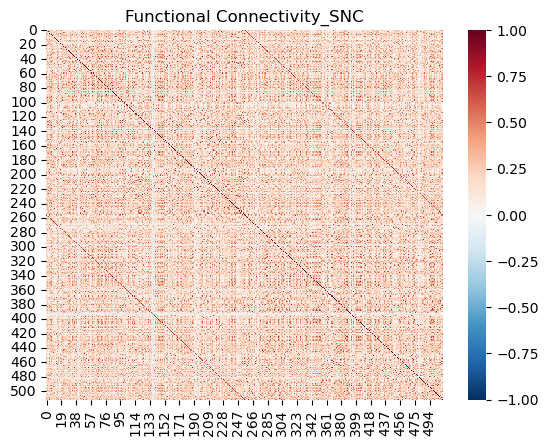

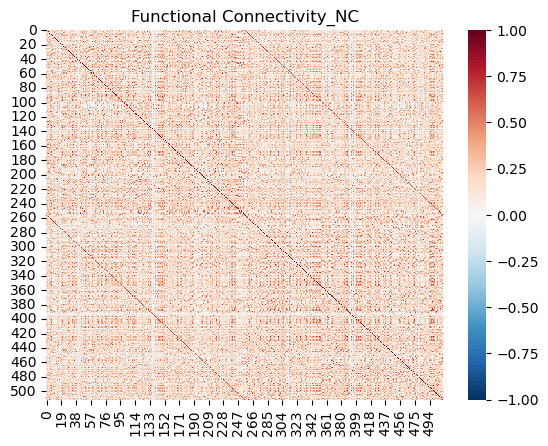

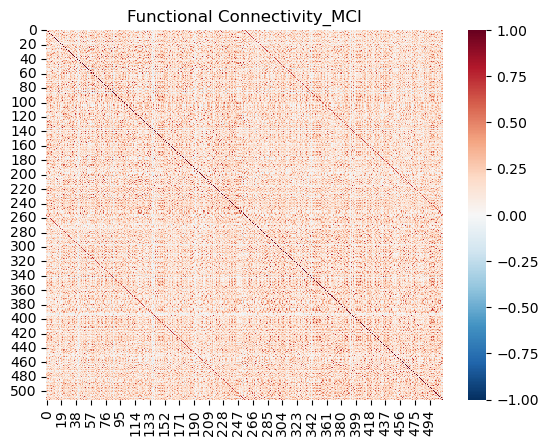

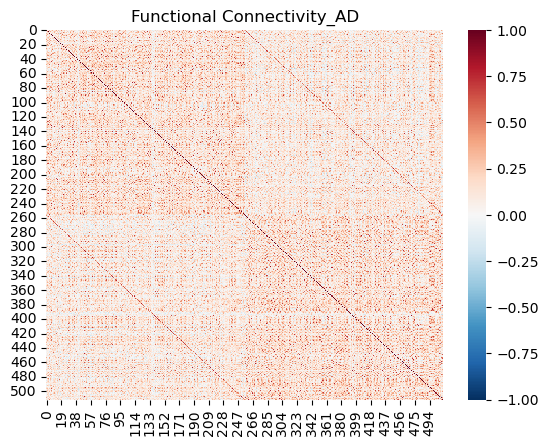

In [61]:
group_list = [SNC_fc, NC_fc, MCI_fc, AD_fc]
name_list = ['SNC', 'NC', 'MCI', 'AD']
for i in range(len(group_list)):
    sns.heatmap(group_list[i], cmap='RdBu_r', vmax = 1.0, vmin = -1.0, center = 0.0)
    plt.title(f'Functional Connectivity_{name_list[i]}')
    plt.show()

In [62]:
# build the network
thre = 0.5
G_AD = build_network(AD_fc, threshold=thre)
G_SNC = build_network(SNC_fc, threshold=thre)
G_NC = build_network(NC_fc, threshold=thre)
G_MCI = build_network(MCI_fc, threshold=thre)
# # relabel the nodes with meta_links
# G = nx.relabel_nodes(G, dict(zip(range(np.shape(meta3d)[0]), meta_links)))


### Number of nodes and edges

In [63]:
print(G_AD.number_of_nodes(), G_AD.number_of_edges())
print(G_SNC.number_of_nodes(), G_SNC.number_of_edges())
print(G_NC.number_of_nodes(), G_NC.number_of_edges())
print(G_MCI.number_of_nodes(), G_MCI.number_of_edges())

512 3689
512 7082
512 5197
512 4974


Text(0.5, 1.0, 'Number of edges')

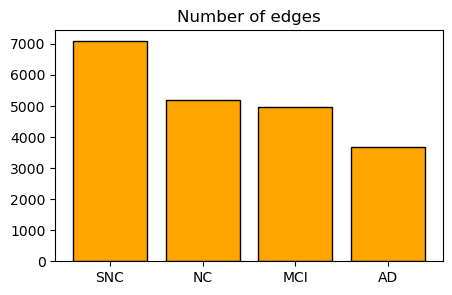

In [64]:
# number of edges
data = [G_SNC.number_of_edges(), G_NC.number_of_edges(), G_MCI.number_of_edges(),G_AD.number_of_edges()]
plt.figure(figsize=(5,3))
plt.bar(['SNC', 'NC', 'MCI', 'AD'], data, color='orange', edgecolor='black')
plt.title('Number of edges')

In [65]:
# Used to calculate the integration

Gp_AD = build_network(AD_fc, threshold=thre, reverse_path=True)
Gp_SNC = build_network(SNC_fc, threshold=thre, reverse_path=True)
Gp_NC = build_network(NC_fc, threshold=thre, reverse_path=True)
Gp_MCI = build_network(MCI_fc, threshold=thre, reverse_path=True)

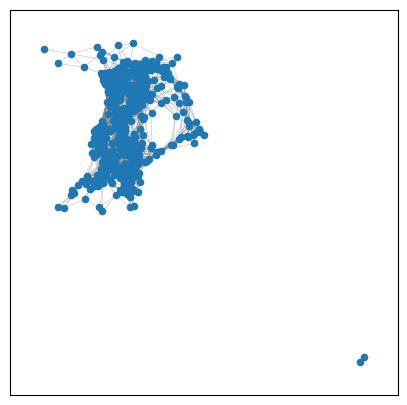

In [66]:
# visualize the network
plt.figure(figsize=(5,5))
nx.draw_networkx(G_SNC, with_labels=False, node_size=20, width=0.2, edge_color='grey')

## Network Analysis

Functions used in the analyses

The workflow of analyses:
1. Node level  
    1. Weighted Degree Distribution
    2. Power-law
    3. Degree centrality  
    4. Eigenvector Centrality
    5. Average Neighbor Degree


2. Modularity level  
    1. Modularity
    2. scalar assortativity: 1. louvain community detection to have best partition; 2. calculate participation coefficient; 3. calculate scalar assortativity.
    3. Integration: Participation coefficient (identify the global intermodular `integration`.)
    4. Segregation: clustering coefficient/tranvitity (identify the local intramodular `segregation`.)


3. Network level
    1. Network Similarity
        1. Motif, building block of the network
        2. Graphlet, calculate the similarity between groups

Some analyses not applicable:

1. FC is correlation based analyses, which means that all the path based analyses are not applicable, including network integration, closeness centrality, betweenness centrality. 
2. However, we can use length of correlation to explore the influence of the one nodes to the other nodes. 
3. The similarity of the network will be measured by motif and graphlet.

### 1.1 Degree distribution and 1.2 power-law

alpha: 2.74 +/- sigma: 0.10
alpha: 3.24 +/- sigma: 0.15
alpha: 3.63 +/- sigma: 0.18
alpha: 4.25 +/- sigma: 0.30


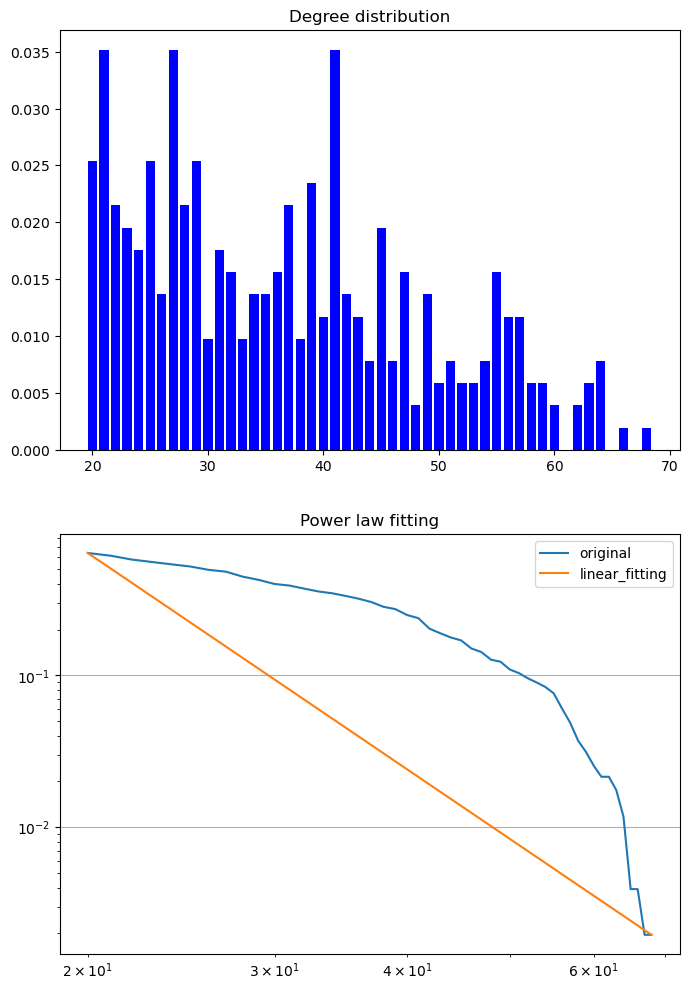

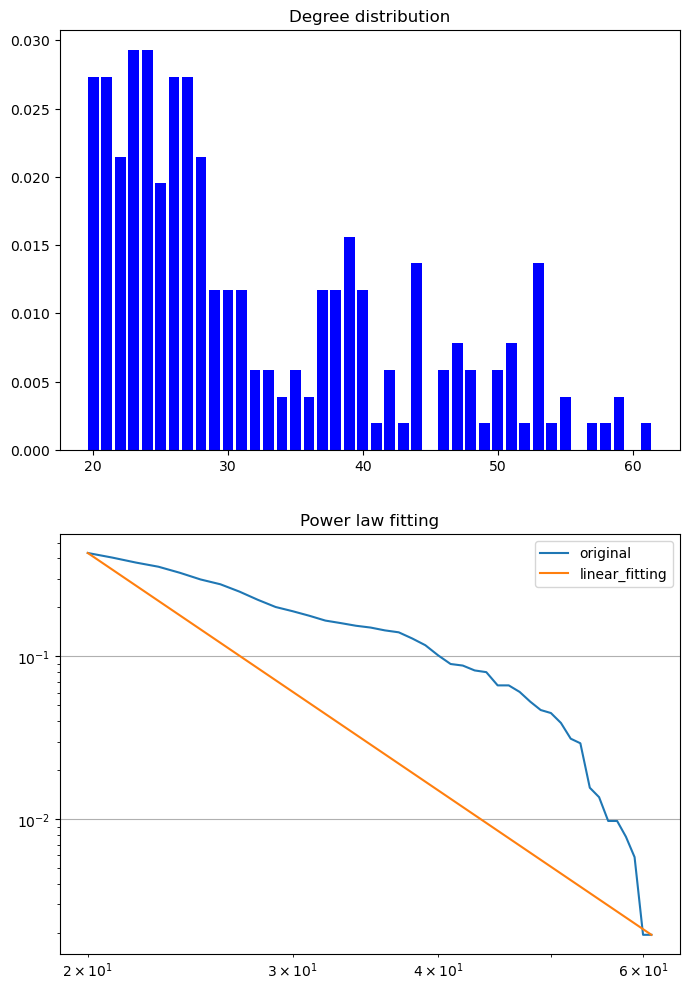

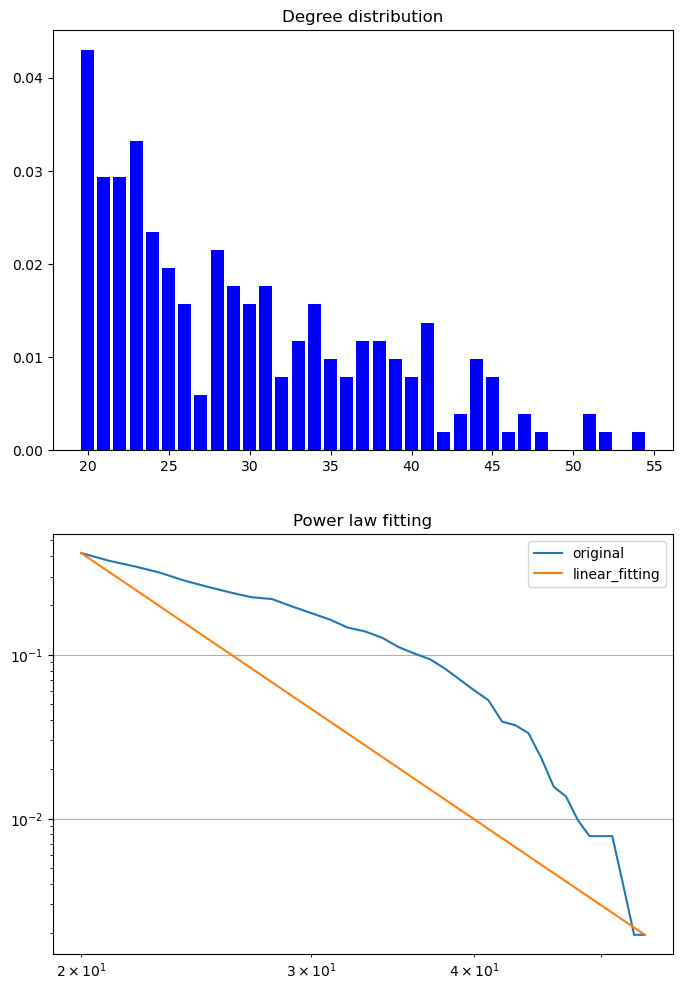

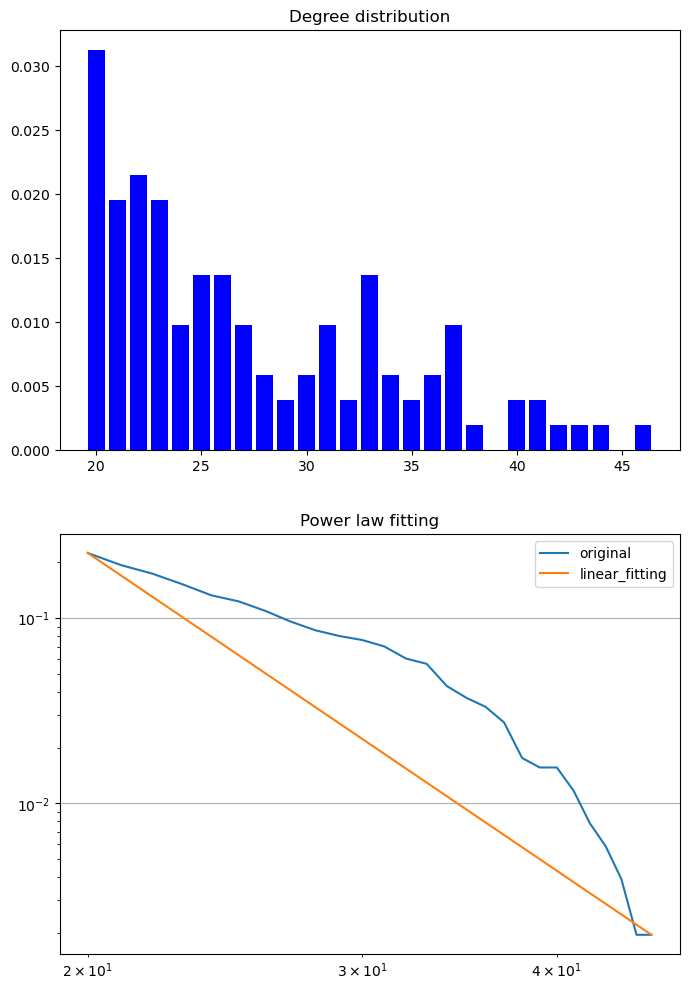

In [67]:
calc_powerlaw(G_SNC,kmin=20) # select kmin!
calc_powerlaw(G_NC,kmin=20) # select kmin!
calc_powerlaw(G_MCI,kmin=20) # select kmin!
calc_powerlaw(G_AD,kmin=20) # select kmin!

### 1.3 Degree centrality

degree centrality, weigted:
  1. Precentral R.11 (40.5724)
  2. Parietal Sup L.8 (40.1854)
  3. Postcentral R.9 (39.8222)
  4. Occipital Mid L.12 (39.2306)
  5. Fusiform L.7 (39.1502)
  6. Supp Motor Area L.2 (39.1397)
  7. Parietal Sup L.5 (39.0520)
  8. Paracentral Lobule R.1 (38.7891)
  9. Fusiform R.10 (38.5343)
  10. Occipital Mid L.1 (37.5561)
degree centrality, weigted:
  1. Parietal Sup L.5 (38.5920)
  2. Postcentral R.7 (37.6316)
  3. Postcentral R.10 (37.1769)
  4. Supp Motor Area L.2 (36.5517)
  5. Postcentral R.9 (36.3324)
  6. Postcentral L.3 (35.6684)
  7. Postcentral L.2 (35.1315)
  8. Postcentral R.3 (34.7644)
  9. Occipital Mid R.1 (34.3231)
  10. Postcentral R.2 (34.2983)
degree centrality, weigted:
  1. Occipital Mid R.1 (33.2484)
  2. Supp Motor Area R.1 (31.4293)
  3. Supp Motor Area L.2 (30.7883)
  4. Precentral R.11 (29.6858)
  5. Parietal Sup L.5 (29.3501)
  6. Parietal Sup L.8 (28.9418)
  7. Postcentral L.3 (28.5815)
  8. Postcentral R.7 (28.3728)
  9. Lingual 

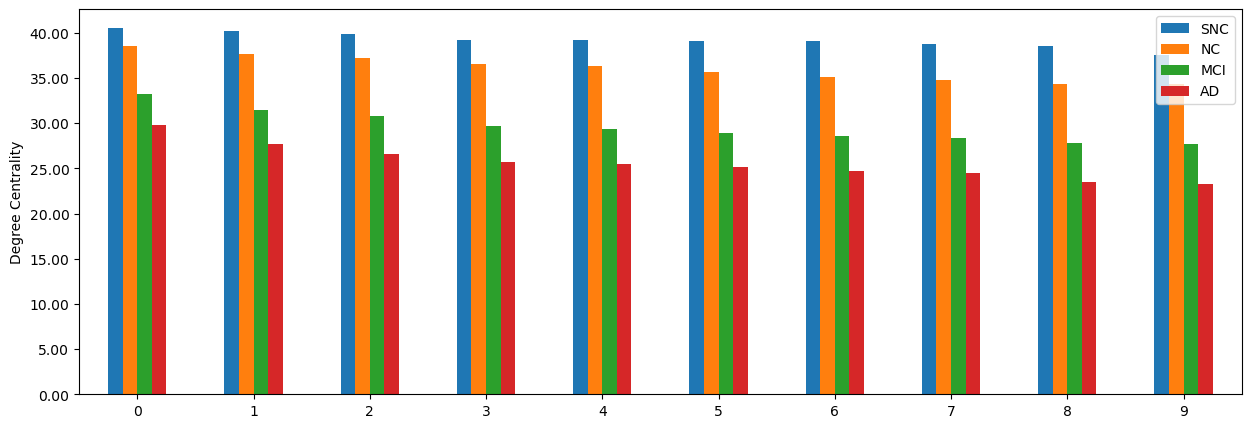

In [68]:

wdc_snc_nodes, wdc_snc_scores = weighted_degree_centrality(G_SNC)
wdc_nc_nodes, wdc_nc_scores = weighted_degree_centrality(G_NC)
wdc_mci_nodes, wdc_mci_scores = weighted_degree_centrality(G_MCI)
wdc_ad_nodes, wdc_ad_scores = weighted_degree_centrality(G_AD)

df = pd.DataFrame({'SNC':wdc_snc_scores[:10], 'NC':wdc_nc_scores[:10], 'MCI':wdc_mci_scores[:10], 'AD':wdc_ad_scores[:10]})


df.plot(kind='bar', figsize=(15,5))
plt.ylabel('Degree Centrality')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_tick_params(rotation=0)
plt.legend(loc='upper right')


### 1.4 Eigenvector centrality

Eigenvector Centrality weighted:
  1. Parietal Sup L.5 (0.1361)
  2. Postcentral R.9 (0.1340)
  3. Postcentral R.3 (0.1303)
  4. Postcentral L.3 (0.1263)
  5. Precentral R.11 (0.1251)
  6. Supp Motor Area L.2 (0.1203)
  7. Precentral L.1 (0.1199)
  8. Postcentral L.2 (0.1193)
  9. Parietal Sup L.1 (0.1189)
  10. Precuneus L.7 (0.1188)
Eigenvector Centrality weighted:
  1. Parietal Sup L.5 (0.1784)
  2. Postcentral L.3 (0.1740)
  3. Postcentral R.10 (0.1705)
  4. Postcentral R.3 (0.1702)
  5. Postcentral L.2 (0.1686)
  6. Postcentral R.9 (0.1682)
  7. Postcentral R.2 (0.1678)
  8. Postcentral L.11 (0.1677)
  9. Postcentral R.7 (0.1653)
  10. Precentral R.2 (0.1598)
Eigenvector Centrality weighted:
  1. Parietal Sup L.5 (0.1859)
  2. Postcentral L.3 (0.1837)
  3. Supp Motor Area R.1 (0.1765)
  4. Postcentral R.9 (0.1750)
  5. Postcentral R.3 (0.1747)
  6. Postcentral L.11 (0.1734)
  7. Postcentral L.2 (0.1699)
  8. Precentral R.11 (0.1688)
  9. Supp Motor Area L.2 (0.1682)
  10. Postcent

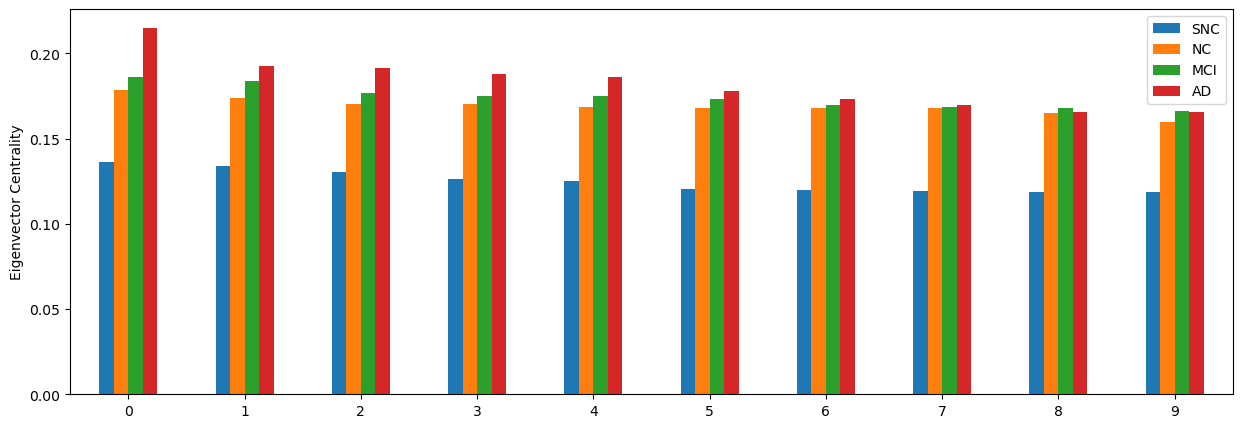

In [69]:
wec_snc_nodes, wec_snc_scores = weighted_eigenvector_centrality(G_SNC)
wec_nc_nodes, wec_nc_scores = weighted_eigenvector_centrality(G_NC)
wec_mci_nodes, wec_mci_scores = weighted_eigenvector_centrality(G_MCI)
wec_ad_nodes, wec_ad_scores = weighted_eigenvector_centrality(G_AD)

df = pd.DataFrame({'SNC':wec_snc_scores[:10], 'NC':wec_nc_scores[:10], 'MCI':wec_mci_scores[:10], 'AD':wec_ad_scores[:10]})


df.plot(kind='bar', figsize=(15,5))
plt.ylabel('Eigenvector Centrality')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_tick_params(rotation=0)
plt.legend(loc='upper right')

### 1.5 Average neighbor degree

Averaging neighor degree, weighted:
  1. Calcarine R.1 (32.5979)
  2. Lingual R.6 (32.4705)
  3. Calcarine L.1 (32.4146)
  4. Occipital Mid L.9 (32.2739)
  5. Cuneus L.3 (31.8576)
  6. Lingual R.5 (31.8429)
  7. Calcarine L.3 (31.8400)
  8. Occipital Mid L.2 (31.8334)
  9. Fusiform R.4 (31.8070)
  10. Lingual L.5 (31.7293)
Averaging neighor degree, weighted:
  1. Postcentral R.10 (52.3101)
  2. Postcentral R.2 (51.4836)
  3. Precentral R.2 (51.1335)
  4. Parietal Sup L.4 (51.0562)
  5. Postcentral L.11 (50.4098)
  6. Parietal Sup R.7 (50.3390)
  7. Parietal Sup R.1 (50.2549)
  8. Postcentral R.7 (50.0939)
  9. Postcentral R.3 (50.0811)
  10. Postcentral R.13 (50.0256)
Averaging neighor degree, weighted:
  1. Precentral R.9 (49.5153)
  2. Precentral L.1 (47.5359)
  3. Postcentral R.11 (47.4755)
  4. Precentral R.2 (47.1619)
  5. Precentral L.6 (47.1254)
  6. Precentral R.7 (47.0525)
  7. Paracentral Lobule L.5 (46.9620)
  8. Precentral L.3 (46.7024)
  9. Postcentral R.13 (46.6816)
  10.

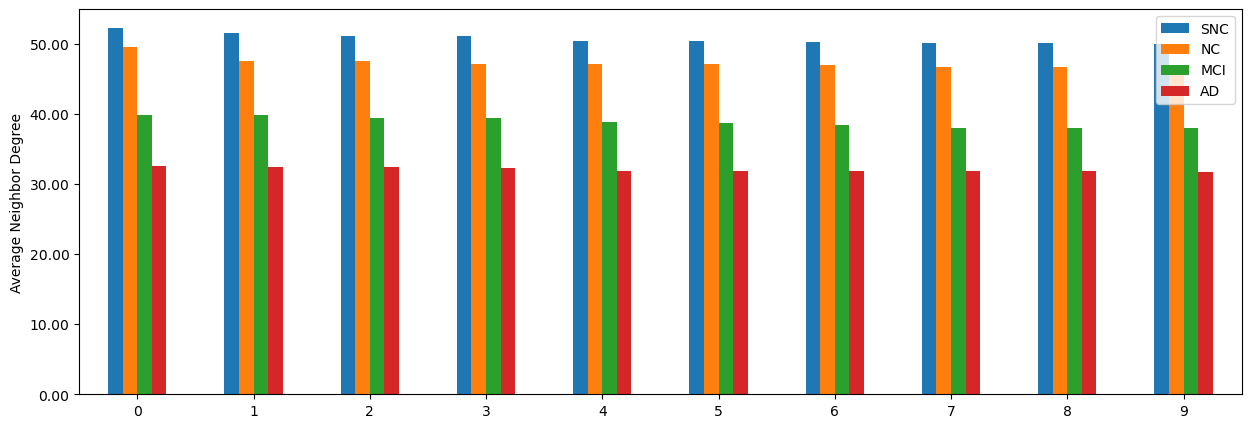

In [70]:
average_neighbor_degree_vector = average_neighbor_degree(G_AD)
print(f'Averaging neighor degree, weighted:')
print_top_num(G_AD, average_neighbor_degree_vector, num=10)


wan_snc_nodes, wan_snc_scores = weighted_average_neighbor(G_SNC)
wan_nc_nodes, wan_nc_scores = weighted_average_neighbor(G_NC)
wan_mci_nodes, wan_mci_scores = weighted_average_neighbor(G_MCI)
wan_ad_nodes, wan_ad_scores = weighted_average_neighbor(G_AD)

df = pd.DataFrame({'SNC':wan_snc_scores[:10], 'NC':wan_nc_scores[:10], 'MCI':wan_mci_scores[:10], 'AD':wan_ad_scores[:10]})


df.plot(kind='bar', figsize=(15,5))
plt.ylabel('Average Neighbor Degree')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_tick_params(rotation=0)
plt.legend(loc='upper right')



## Modularity level

### 2.1 Modularity & Scalar Associativity

Text(0.5, 1.0, 'Modularity based on Hemispheric connections between brain regions')

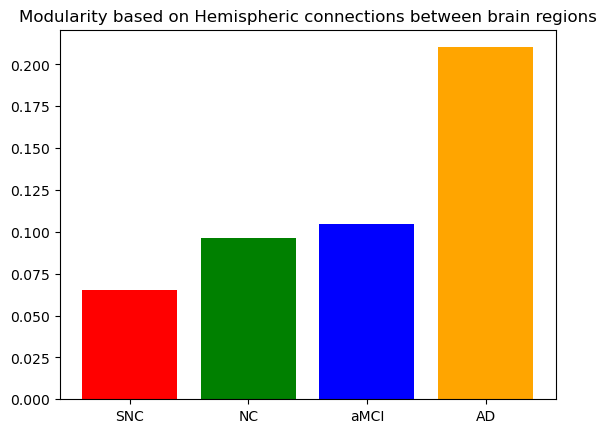

In [71]:
# modularity
ml_snc = nx.community.modularity(G_SNC, lf_communities.values())
ml_nc = nx.community.modularity(G_NC, lf_communities.values())
ml_mci = nx.community.modularity(G_MCI, lf_communities.values())
ml_ad = nx.community.modularity(G_AD, lf_communities.values())

data = [ml_snc, ml_nc, ml_mci, ml_ad]
labels = ['SNC', 'NC', 'aMCI', 'AD']
plt.bar(labels, data, color=['red', 'green', 'blue', 'orange'])
plt.title('Modularity based on Hemispheric connections between brain regions')


### 2.2.1 Integration: Diameter

[3.90680655429924, 3.958487636060902, 4.7078916172169345, 5.132278315248149]


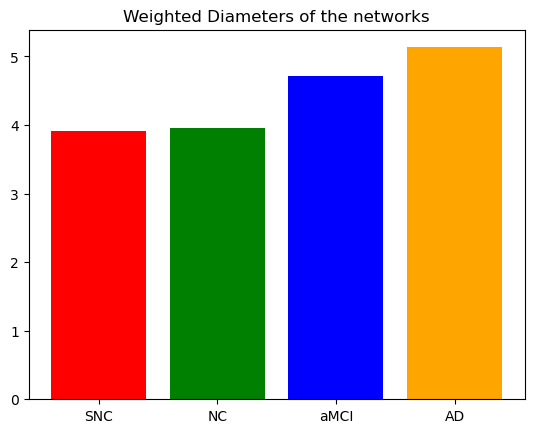

In [72]:
ad_dia = calculate_diameter(Gp_AD)
nc_dia = calculate_diameter(Gp_NC)
mci_dia = calculate_diameter(Gp_MCI)
snc_dia = calculate_diameter(Gp_SNC)
data = [snc_dia, nc_dia, mci_dia, ad_dia]
print(data)
labels = ['SNC', 'NC', 'aMCI', 'AD']
plt.bar(labels, data, color=['red', 'green', 'blue', 'orange'])
plt.title('Weighted Diameters of the networks')
plt.show()

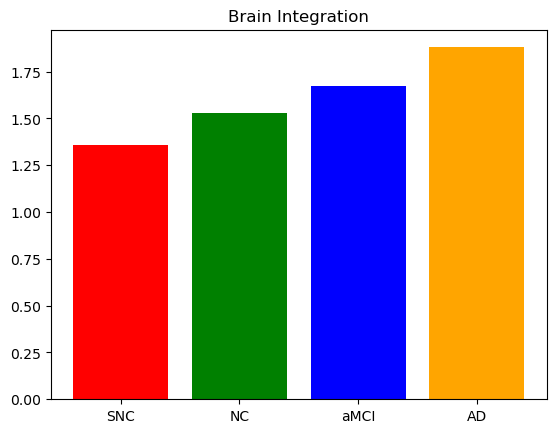

[0.37435727412540265, 0.3439443432606495, 0.3612235178078002, 0.33395401222667587]


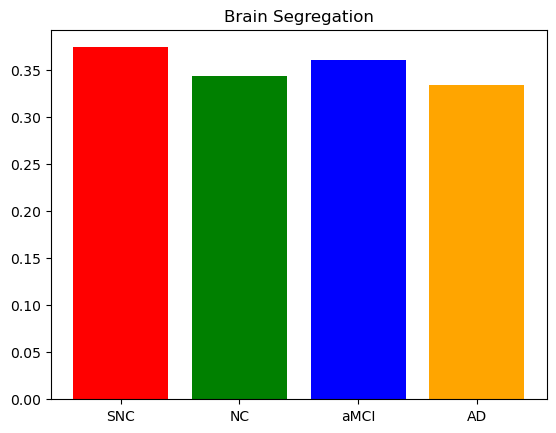

In [73]:
# nx.transitivity(G_AD)
# segregation
snc_seg = nx.average_clustering(G_SNC, weight='weight')
nc_seg = nx.average_clustering(G_NC, weight='weight')
mci_seg = nx.average_clustering(G_MCI, weight='weight')
ad_seg = nx.average_clustering(G_AD, weight='weight')

# integration
snc_int = average_shortest(Gp_SNC)
nc_int = average_shortest(Gp_NC)
mci_int = average_shortest(Gp_MCI)
ad_int = average_shortest(Gp_AD)

data_int = [snc_int, nc_int, mci_int, ad_int]
labels = ['SNC', 'NC', 'aMCI', 'AD']
plt.bar(labels, data_int, color=['red', 'green', 'blue', 'orange'])
plt.title('Brain Integration')
plt.show()

data_seg = [snc_seg, nc_seg, mci_seg, ad_seg]
print(data_seg)
labels = ['SNC', 'NC', 'aMCI', 'AD']
plt.bar(labels, data_seg, color=['red', 'green', 'blue', 'orange'])
plt.title('Brain Segregation')
plt.show()

In [74]:
# create scalar for each community
ad_d_communities = make_d_scalar(G_AD, df_parcel)
nc_d_communities = make_d_scalar(G_NC, df_parcel)
mci_d_communities = make_d_scalar(G_MCI, df_parcel)
snc_d_communities = make_d_scalar(G_SNC, df_parcel)

# calculate scalar assortativity
sa_snc = quick_scalar_assortativity(G_SNC, snc_d_communities)
sa_nc = quick_scalar_assortativity(G_NC, nc_d_communities)
sa_mci = quick_scalar_assortativity(G_MCI, mci_d_communities)
sa_ad = quick_scalar_assortativity(G_AD, ad_d_communities)

Text(0.5, 1.0, 'Scalar Assortativity based on Participation Coefficient')

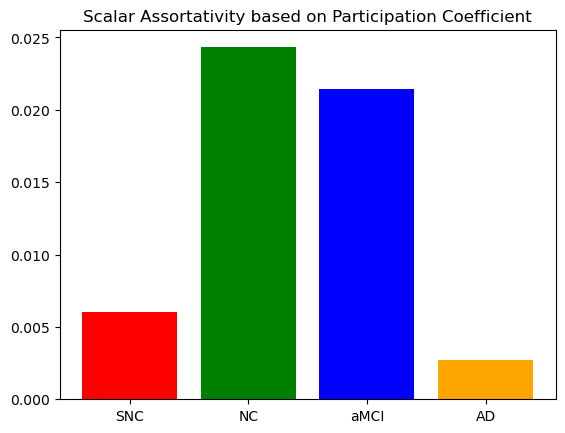

In [75]:
data = [sa_snc, sa_nc, sa_mci, sa_ad]
labels = ['SNC', 'NC', 'aMCI', 'AD']
plt.bar(labels, data, color=['red', 'green', 'blue', 'orange'])
plt.title('Scalar Assortativity based on Participation Coefficient')

### 2.2.2 Average clustering coefficient

Text(0.5, 1.0, 'Transitivity of the networks')

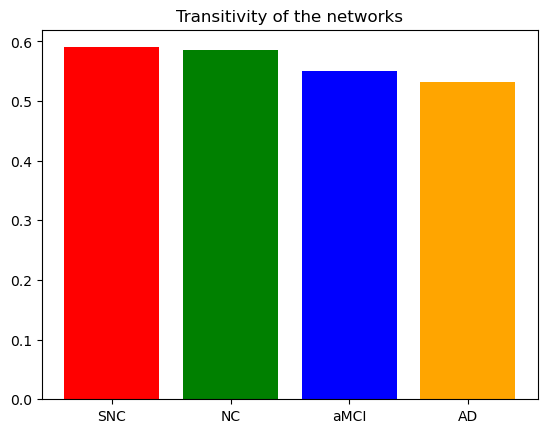

In [76]:
ad_tria = nx.transitivity(G_AD)
nc_tria = nx.transitivity(G_NC)
mci_tria = nx.transitivity(G_MCI)
snc_tria = nx.transitivity(G_SNC)

data_tria = [snc_tria, nc_tria, mci_tria, ad_tria]
labels = ['SNC', 'NC', 'aMCI', 'AD']
plt.bar(labels, data_tria, color=['red', 'green', 'blue', 'orange'])
plt.title('Transitivity of the networks')

## 3 Network Level

### 3.2 Network Similarity

In [77]:
H = G_AD.subgraph([i for i in list(G_AD.nodes())[:10]])
print(H.edges())

[('Frontal Inf Orb L.3', 'Temporal Pole Sup L.1'), ('Frontal Inf Orb L.3', 'Olfactory L.1'), ('Frontal Inf Orb L.3', 'Temporal Pole Mid L.3'), ('Temporal Pole Sup L.5', 'Temporal Pole Sup L.1'), ('Olfactory L.1', 'Temporal Pole Sup L.1'), ('Olfactory L.1', 'Temporal Pole Mid L.3'), ('Temporal Pole Sup L.1', 'Temporal Pole Mid L.3'), ('Supp Motor Area L.3', 'Frontal Sup L.1'), ('Frontal Mid L.8', 'Frontal Sup L.1'), ('Frontal Mid L.8', 'Frontal Mid L.4'), ('Frontal Sup L.1', 'Frontal Mid L.4'), ('Frontal Sup L.1', 'Paracentral Lobule L.2')]


### 3.2.1 Motif

Motif is calculated by `netsci` pacakage

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[0.9988637937812591, 0.9986150777653331, 0.9964460817575718, 0.9999876818115802, 0.9993280840537332, 0.9994975645993067]


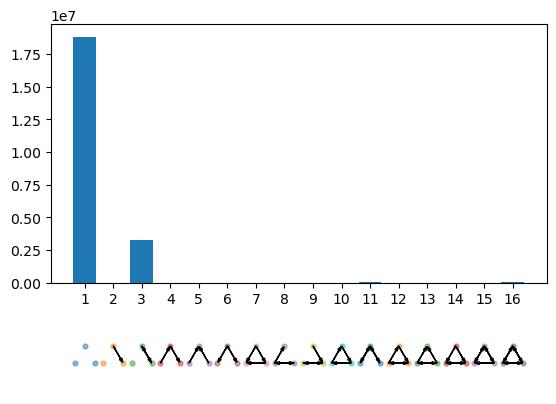

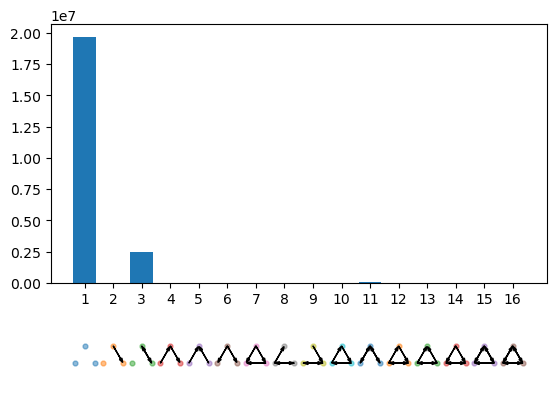

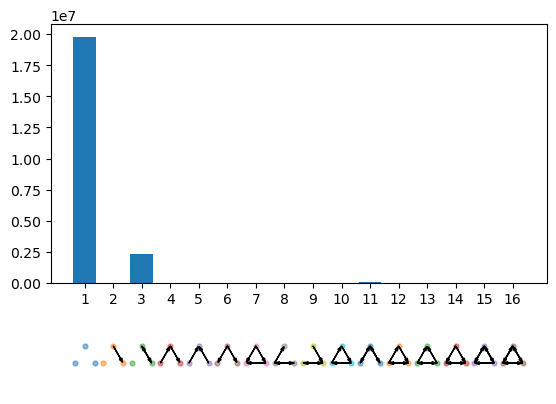

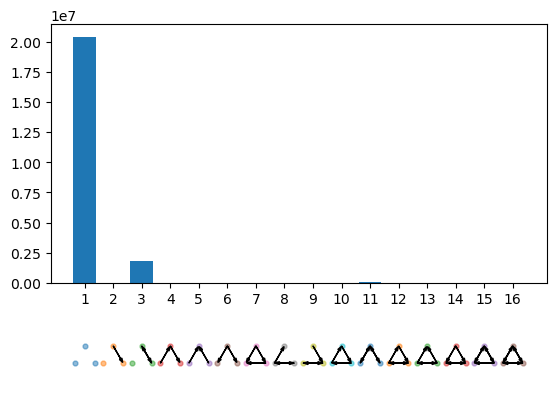

In [78]:
f_snc = calculate_motif(G_SNC)
f_nc = calculate_motif(G_NC)
f_mci = calculate_motif(G_MCI)
f_ad = calculate_motif(G_AD)

f1 = [f_snc, f_nc, f_mci, f_ad]
sim_list = calculate_similarity(f1)
print(sim_list)

### 3.2.2 Graphlets

### Math of the Graphlets Degree Distribution Agreement

$
S^j_G(k) = \frac{d^j_G(k)}{k}
$

$
T^j_G = \sum_{k=1}^{k_{max}} S^j_G(k)
$

$
N^j_G(k) = \frac{S^j_G(k)}{T^j_G}
$

$
D^j(G, H) = \sqrt(\sum_{k=1}^{k_{max}} [N^j_G(k) - N^j_H(k)]^2)
$

$
A^j(G, H) = 1 - D^j(G, H)
$

$
A_{arith}(G, H) = 1/73 * \sum_{j=0}^{72} A^j(G, H)
$

$
A_{geo}(G, H) = \sqrt[73]{\prod_{j=0}^{72} A^j(G, H)}
$

### Graphlet

For the graphlet part, I did two things: 1. use OrbitalFeatures to calculate all the graphlets orbit counts for each node; 2. use the graphlet degree distribution agreement to calculate the similarity between groups.

In [79]:
### I will use a python script called "OrbitalFeatures" to extract the features from the network
# !python /Users/yilewang/Documents/OrbitalFeatures/scr/main.py --graph-input edgelist.csv --output output.csv --graphlet-size 5

# create graphlets degree distribution
# import AD_graphlet
AD_graphlets_table = pd.read_csv('AD_graphlets.csv')
SNC_graphlets_table = pd.read_csv('SNC_graphlets.csv')
NC_graphlets_table = pd.read_csv('NC_graphlets.csv')
MCI_graphlets_table = pd.read_csv('MCI_graphlets.csv')

In [80]:
print(graphlets_DD_agreement(AD_graphlets_table, SNC_graphlets_table, mode = 'arith', number_of_orbits = 67))
print(graphlets_DD_agreement(AD_graphlets_table, NC_graphlets_table, mode = 'arith', number_of_orbits = 67))
print(graphlets_DD_agreement(AD_graphlets_table, MCI_graphlets_table, mode = 'arith', number_of_orbits = 67))
print(graphlets_DD_agreement(SNC_graphlets_table, NC_graphlets_table, mode = 'arith', number_of_orbits = 67))

0.9087089186166475
0.9167191482962214
0.9128131369178741
0.9179747601087311


In [81]:
print(graphlets_DD_agreement(SNC_graphlets_table, MCI_graphlets_table, mode = 'arith', number_of_orbits = 67))
print(graphlets_DD_agreement(NC_graphlets_table, MCI_graphlets_table, mode = 'arith', number_of_orbits = 67))

0.9192254684893594
0.9215575918521295


In [82]:
print(graphlets_DD_agreement(SNC_graphlets_table, MCI_graphlets_table, mode = 'geo', number_of_orbits = 67))
print(graphlets_DD_agreement(NC_graphlets_table, MCI_graphlets_table, mode = 'geo', number_of_orbits = 67))

0.9339785928768185
0.9364413055103941


In [83]:
print(graphlets_DD_agreement(AD_graphlets_table, SNC_graphlets_table, mode = 'geo', number_of_orbits = 67))
print(graphlets_DD_agreement(AD_graphlets_table, NC_graphlets_table, mode = 'geo', number_of_orbits = 67))
print(graphlets_DD_agreement(AD_graphlets_table, MCI_graphlets_table, mode = 'geo', number_of_orbits = 67))
print(graphlets_DD_agreement(SNC_graphlets_table, NC_graphlets_table, mode = 'geo', number_of_orbits = 67))

0.9232265955238189
0.9315605242392149
0.9276339044919695
0.9327795627661244
